# 1D Heat Equation Performance
This notebook provides comprehensive evaluation and visualization of the trained Koopman Autoencoder model.

## Contents:
1. Model Loading and Setup
2. Basic Performance Metrics
3. Reconstruction Quality Analysis
4. Multi-step Prediction Evaluation
5. Latent Space Analysis
6. Physics Constraint Verification
7. Koopman Operator Analysis
8. Comparison with Baselines
9. Save results

## 1. Setup and Model Loading

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml
import json
import h5py
from tqdm.notebook import tqdm
from IPython.display import display, HTML
import pandas as pd

# Scientific computing
from scipy import stats
from scipy.linalg import eig
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Custom imports
import sys
sys.path.append('../../src')  # Adjust path as needed
from models.koopman_ae import create_koopman_ae
from utils.trainer import load_checkpoint
from utils.pde_dataloader import PDEDataset, create_dataloaders

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [2]:
# Configuration
MODEL_PATH = '../../results/checkpoints/koopman_ae_heat1d_20250611_184031/best_model.pt'  # Update this
CONFIG_PATH = '../../results/checkpoints/koopman_ae_heat1d_20250611_184031/config.yaml'
DATA_PATH = '../../data/1DHeatEq/heat1d_data.h5'  # Update based on dataset

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### 1.1 Load Model and Configuration

In [3]:
# Load configuration
with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)
    
print("Configuration loaded:")
print(f"Dataset: {config['dataset']}")
print(f"Model architecture: {config['model']}")

# Load model
model = create_koopman_ae(config)
checkpoint = load_checkpoint(MODEL_PATH, model, device=device)

print(f"\nModel loaded from epoch {checkpoint['epoch']}")
print(f"Best validation loss: {checkpoint['best_val_loss']:.6f}")

# Load training history if available
losses_path = MODEL_PATH.replace('.pt', '_losses.json')
if Path(losses_path).exists():
    with open(losses_path, 'r') as f:
        training_history = json.load(f)
else:
    training_history = None

model.eval()

Configuration loaded:
Dataset: heat1d
Model architecture: {'activation': 'relu', 'dropout': 0.1, 'hidden_dims_decoder': [256, 128, 64], 'hidden_dims_encoder': [64, 128, 256], 'latent_dim': 32, 'operator_type': 'linear', 'use_batch_norm': True}

Model loaded from epoch 28
Best validation loss: 1.139319


KoopmanAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=100, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=64, out_features=128, bias=True)
      (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=128, out_features=256, bias=True)
      (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): Dropout(p=0.1, inplace=False)
      (12): Linear(in_features=256, out_features=32, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=32, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()


### 1.2 Load Test Data

In [4]:
# Create test dataloader
_, _, test_loader = create_dataloaders(
    DATA_PATH,
    batch_size=32,
    input_steps=config.get('input_steps', 10),
    output_steps=config.get('output_steps', 10),
    normalize=config.get('normalize', True)
)

# Load full dataset for trajectory analysis
test_dataset = PDEDataset(
    DATA_PATH, 
    split='test',
    input_steps=config.get('input_steps', 10),
    output_steps=config.get('output_steps', 10),
    normalize=config.get('normalize', True)
)

print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of test batches: {len(test_loader)}")

# Get dataset metadata
with h5py.File(DATA_PATH, 'r') as f:
    x_coords = f['test']['x'][:]
    t_coords = f['test']['t'][:]
    if 'y' in f['test']:
        y_coords = f['test']['y'][:]
        is_2d = True
    else:
        is_2d = False

Test dataset size: 16200
Number of test batches: 507


## 2. Training History Visualization

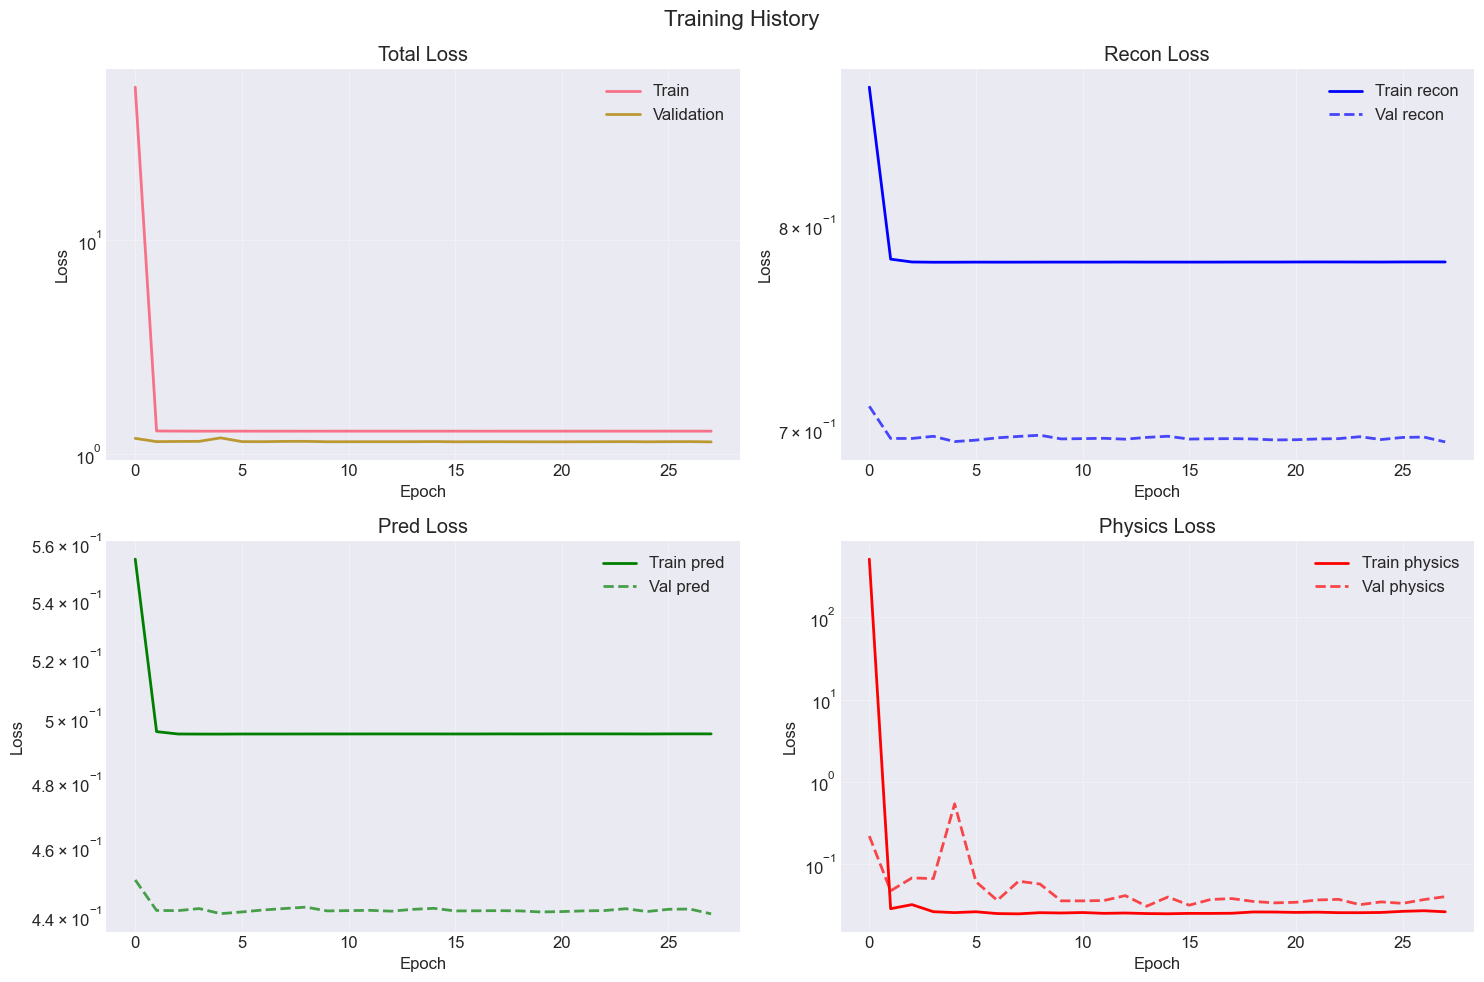


Final Training Losses:
  total: 1.279216
  recon: 0.781372
  pred: 0.495185
  physics: 0.026595
  linearity: 0.000000


In [5]:
if training_history:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training History', fontsize=16)
    
    # Total loss
    axes[0, 0].plot(training_history['train_losses']['total'], label='Train', linewidth=2)
    axes[0, 0].plot(training_history['val_losses']['total'], label='Validation', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].legend()
    axes[0, 0].set_yscale('log')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Component losses
    loss_components = ['recon', 'pred', 'physics']
    colors = ['blue', 'green', 'red']
    
    for i, (loss_name, color) in enumerate(zip(loss_components, colors)):
        ax = axes[(i+1)//2, (i+1)%2]
        if loss_name in training_history['train_losses']:
            ax.plot(training_history['train_losses'][loss_name], 
                   label=f'Train {loss_name}', color=color, linewidth=2)
            ax.plot(training_history['val_losses'][loss_name], 
                   label=f'Val {loss_name}', color=color, alpha=0.7, linestyle='--', linewidth=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title(f'{loss_name.capitalize()} Loss')
        ax.legend()
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final losses
    print("\nFinal Training Losses:")
    for key, values in training_history['train_losses'].items():
        if values:
            print(f"  {key}: {values[-1]:.6f}")
else:
    print("No training history found")

## 3. Reconstruction Quality Analysis

In [6]:
# Get a batch of test data
test_batch = next(iter(test_loader))
inputs = test_batch['input'].to(device)
targets = test_batch['target'].to(device)

# Flatten spatial dimensions if needed
if inputs.dim() == 4:  # 2D data
    batch_size, time_steps, nx, ny = inputs.shape
    inputs_flat = inputs.reshape(batch_size, time_steps, -1)
else:
    inputs_flat = inputs

# Get reconstructions
with torch.no_grad():
    # Single time step reconstruction
    last_frame = inputs_flat[:, -1, :]
    outputs = model(last_frame, n_steps=0, return_latent=True)
    reconstruction = outputs['reconstruction']

# Compute reconstruction metrics
recon_mse = torch.nn.functional.mse_loss(reconstruction, last_frame).item()
recon_mae = torch.nn.functional.l1_loss(reconstruction, last_frame).item()
recon_rel_error = torch.norm(reconstruction - last_frame) / torch.norm(last_frame)

print(f"Reconstruction Metrics:")
print(f"  MSE: {recon_mse:.6f}")
print(f"  MAE: {recon_mae:.6f}")
print(f"  Relative Error: {recon_rel_error:.4%}")

Reconstruction Metrics:
  MSE: 0.437182
  MAE: 0.619890
  Relative Error: 74.7593%


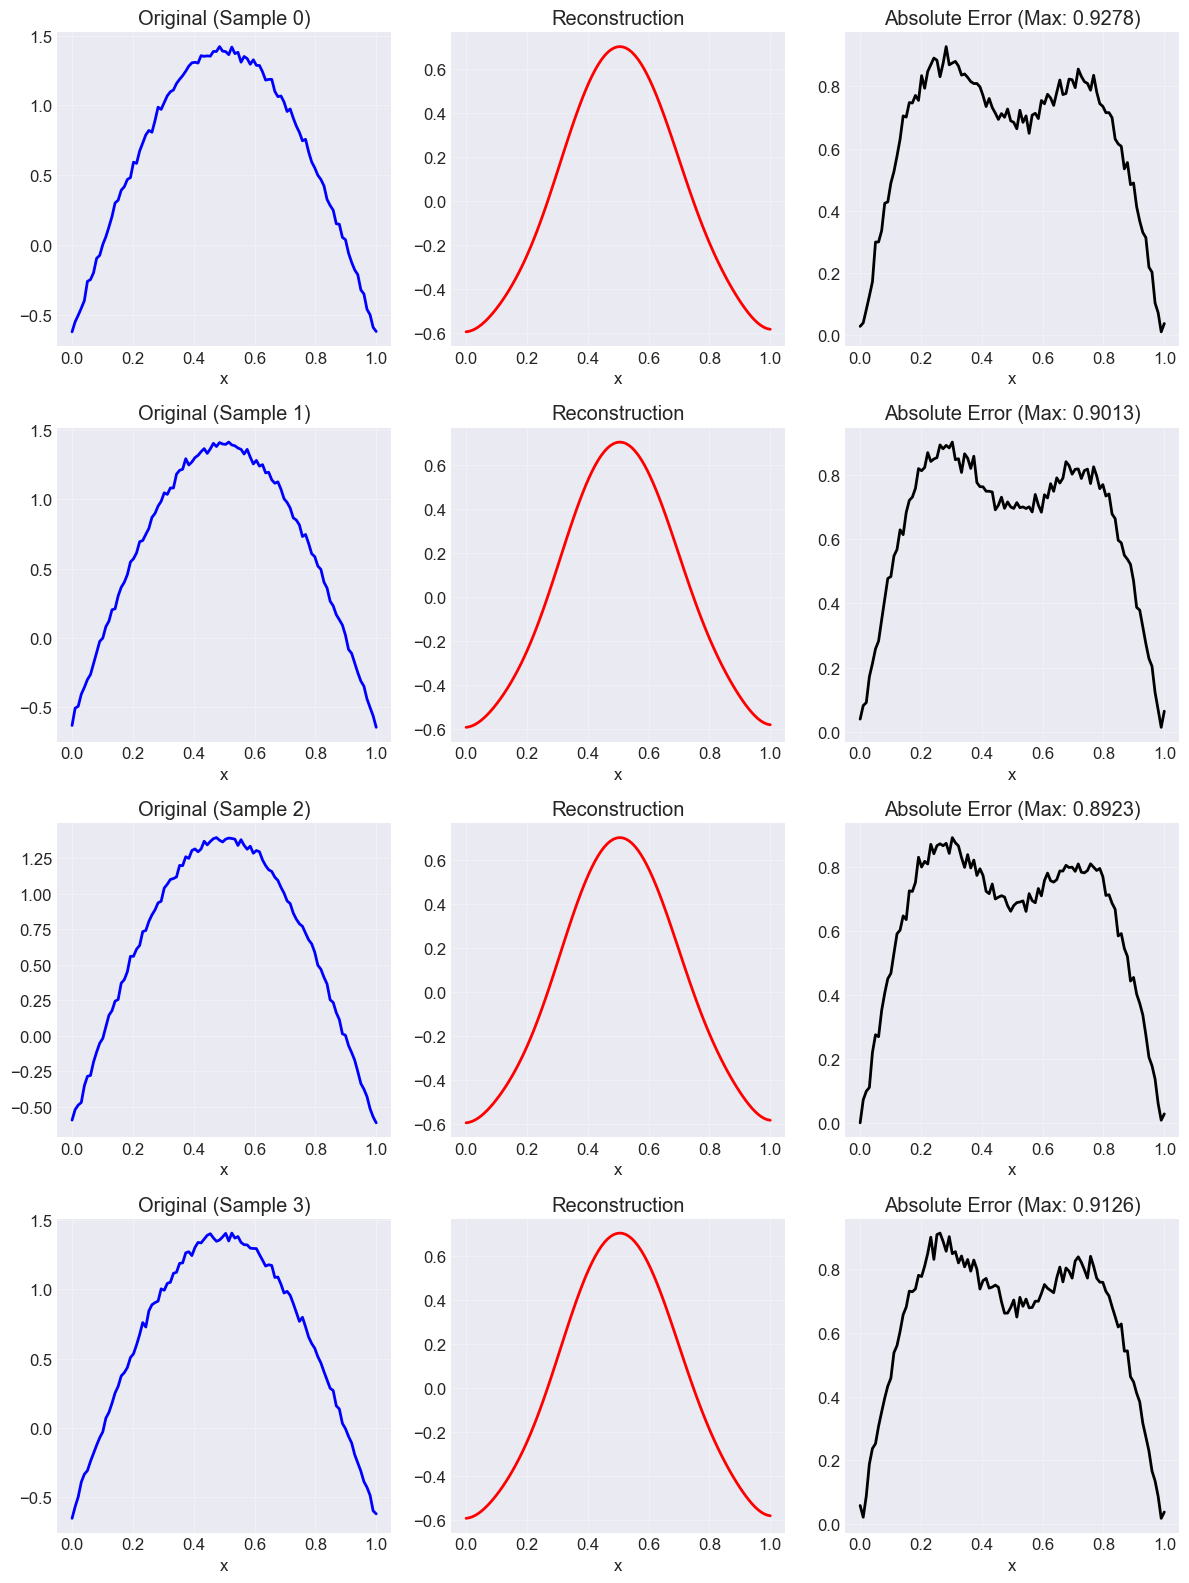

In [7]:
# Visualize reconstructions
n_samples = min(4, inputs.shape[0])
fig, axes = plt.subplots(n_samples, 3, figsize=(12, 4*n_samples))
if n_samples == 1:
    axes = axes.reshape(1, -1)

for i in range(n_samples):
    # Original
    original = last_frame[i].cpu().numpy()
    recon = reconstruction[i].cpu().numpy()
    error = np.abs(original - recon)
    
    if is_2d:
        # Reshape for 2D visualization
        original = original.reshape(nx, ny)
        recon = recon.reshape(nx, ny)
        error = error.reshape(nx, ny)
        
        im1 = axes[i, 0].imshow(original, cmap='viridis', aspect='auto')
        axes[i, 0].set_title(f'Original (Sample {i})')
        plt.colorbar(im1, ax=axes[i, 0])
        
        im2 = axes[i, 1].imshow(recon, cmap='viridis', aspect='auto')
        axes[i, 1].set_title('Reconstruction')
        plt.colorbar(im2, ax=axes[i, 1])
        
        im3 = axes[i, 2].imshow(error, cmap='hot', aspect='auto')
        axes[i, 2].set_title(f'Absolute Error (Max: {error.max():.4f})')
        plt.colorbar(im3, ax=axes[i, 2])
    else:
        # 1D visualization
        axes[i, 0].plot(x_coords, original, 'b-', linewidth=2)
        axes[i, 0].set_title(f'Original (Sample {i})')
        axes[i, 0].set_xlabel('x')
        axes[i, 0].grid(True, alpha=0.3)
        
        axes[i, 1].plot(x_coords, recon, 'r-', linewidth=2)
        axes[i, 1].set_title('Reconstruction')
        axes[i, 1].set_xlabel('x')
        axes[i, 1].grid(True, alpha=0.3)
        
        axes[i, 2].plot(x_coords, error, 'k-', linewidth=2)
        axes[i, 2].set_title(f'Absolute Error (Max: {error.max():.4f})')
        axes[i, 2].set_xlabel('x')
        axes[i, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Multi-step Prediction Evaluation

In [8]:
# Evaluate multi-step predictions
n_pred_steps = config.get('output_steps', 10)

with torch.no_grad():
    # Get predictions
    outputs = model(inputs_flat[:, -1, :], n_steps=n_pred_steps, return_latent=True)
    predictions = outputs['predictions']

# Compare with ground truth
pred_errors = []
for t in range(n_pred_steps):
    if t < targets.shape[1]:
        target_t = targets[:, t, :].reshape(targets.shape[0], -1)
        pred_t = predictions[:, t, :]
        mse_t = torch.nn.functional.mse_loss(pred_t, target_t).item()
        pred_errors.append(mse_t)


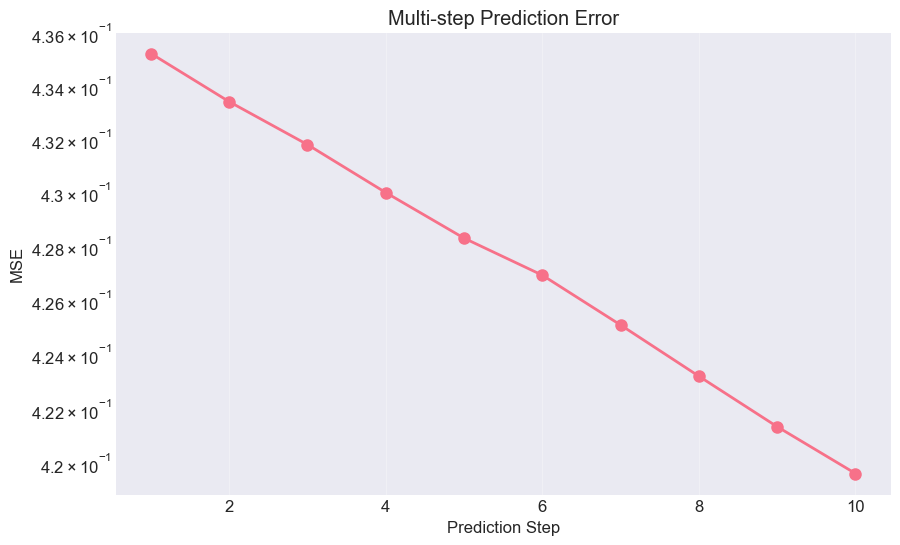

Average prediction error: 0.427474
Error growth rate: 0.96x


In [9]:
# Plot prediction errors over time
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pred_errors)+1), pred_errors, 'o-', linewidth=2, markersize=8)
plt.xlabel('Prediction Step')
plt.ylabel('MSE')
plt.title('Multi-step Prediction Error')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

print(f"Average prediction error: {np.mean(pred_errors):.6f}")
print(f"Error growth rate: {(pred_errors[-1]/pred_errors[0]):.2f}x")


In [10]:
# Visualize prediction trajectory
sample_idx = 0  # Which sample to visualize

# Get full trajectory from one sample
trajectory = test_dataset.get_full_trajectory(sample_idx)
u_full = trajectory['u']

# Get model predictions for longer horizon
with torch.no_grad():
    # Normalize initial condition if needed
    if config.get('normalize', True):
        mean = test_dataset.mean
        std = test_dataset.std
        u0 = (u_full[0] - mean) / (std + 1e-8)
    else:
        u0 = u_full[0]
    
    # Flatten if 2D
    if u0.ndim > 1:
        u0_flat = u0.flatten()
    else:
        u0_flat = u0
    
    # Predict trajectory
    u0_tensor = torch.FloatTensor(u0_flat).unsqueeze(0).to(device)
    traj_output = model.predict_trajectory(u0_tensor, n_steps=50, return_latent=True)
    pred_trajectory = traj_output['trajectory'].squeeze(0).cpu().numpy()
    
    # Denormalize if needed
    if config.get('normalize', True):
        pred_trajectory = pred_trajectory * std + mean

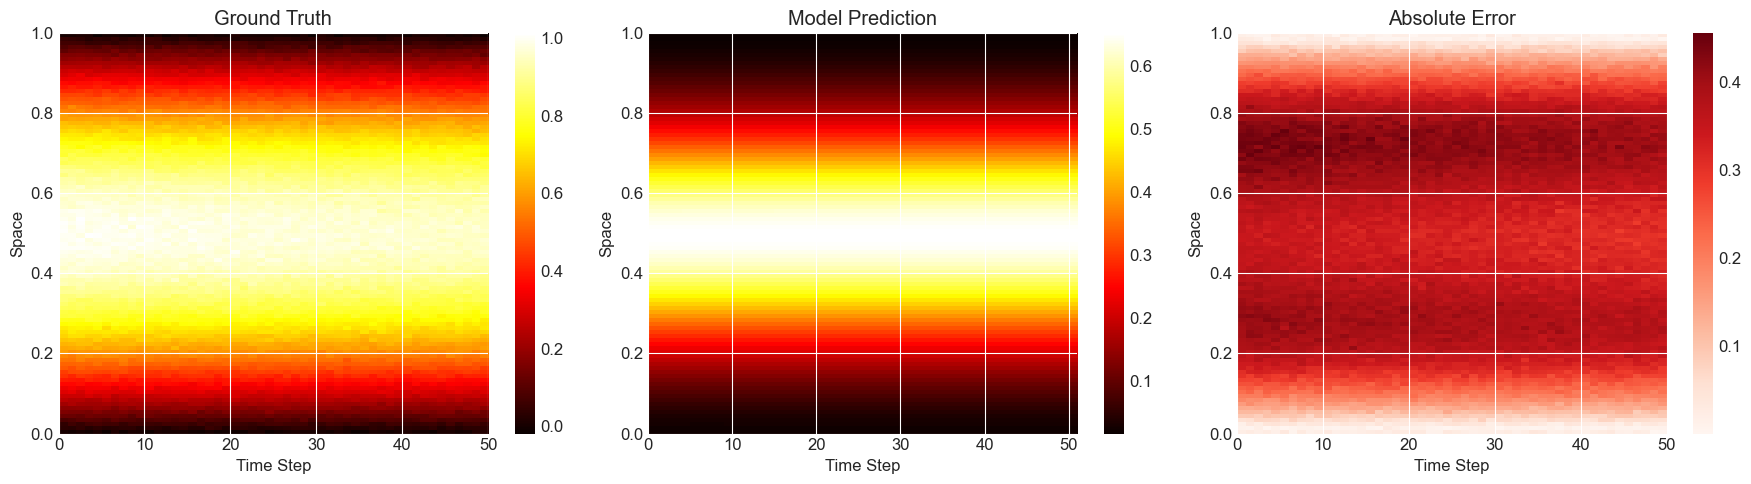

In [11]:
# Visualize trajectory comparison
if is_2d:
    # For 2D data, show snapshots at different times
    time_indices = [0, 10, 20, 30, 40]
    fig, axes = plt.subplots(2, len(time_indices), figsize=(20, 8))
    
    for i, t_idx in enumerate(time_indices):
        if t_idx < u_full.shape[0]:
            # Ground truth
            im1 = axes[0, i].imshow(u_full[t_idx].reshape(nx, ny), 
                                   cmap='viridis', vmin=u_full.min(), vmax=u_full.max())
            axes[0, i].set_title(f'Truth (t={t_idx})')
            
        if t_idx < pred_trajectory.shape[0]:
            # Prediction
            im2 = axes[1, i].imshow(pred_trajectory[t_idx].reshape(nx, ny), 
                                   cmap='viridis', vmin=u_full.min(), vmax=u_full.max())
            axes[1, i].set_title(f'Prediction (t={t_idx})')
    
    plt.tight_layout()
    plt.show()
else:
    # For 1D data, show space-time plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Ground truth
    im1 = axes[0].imshow(u_full[:50].T, aspect='auto', cmap='hot', 
                        extent=[0, 50, x_coords[0], x_coords[-1]])
    axes[0].set_xlabel('Time Step')
    axes[0].set_ylabel('Space')
    axes[0].set_title('Ground Truth')
    plt.colorbar(im1, ax=axes[0])
    
    # Prediction
    im2 = axes[1].imshow(pred_trajectory.T, aspect='auto', cmap='hot',
                        extent=[0, pred_trajectory.shape[0], x_coords[0], x_coords[-1]])
    axes[1].set_xlabel('Time Step')
    axes[1].set_ylabel('Space')
    axes[1].set_title('Model Prediction')
    plt.colorbar(im2, ax=axes[1])
    
    # Error
    min_t = min(50, pred_trajectory.shape[0])
    error = np.abs(u_full[:min_t] - pred_trajectory[:min_t])
    im3 = axes[2].imshow(error.T, aspect='auto', cmap='Reds',
                        extent=[0, min_t, x_coords[0], x_coords[-1]])
    axes[2].set_xlabel('Time Step')
    axes[2].set_ylabel('Space')
    axes[2].set_title('Absolute Error')
    plt.colorbar(im3, ax=axes[2])
    
    plt.tight_layout()
    plt.show()

## 5. Latent Space Analysis

In [12]:
# Collect latent representations
latent_representations = []
original_states = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Encoding test data"):
        inputs = batch['input'].to(device)
        if inputs.dim() == 4:
            inputs = inputs.reshape(inputs.shape[0], inputs.shape[1], -1)
        
        # Encode last time step
        z = model.encode(inputs[:, -1, :])
        latent_representations.append(z.cpu().numpy())
        original_states.append(inputs[:, -1, :].cpu().numpy())

latent_representations = np.concatenate(latent_representations, axis=0)
original_states = np.concatenate(original_states, axis=0)

print(f"Latent space dimension: {latent_representations.shape[1]}")
print(f"Number of samples: {latent_representations.shape[0]}")

Encoding test data:   0%|          | 0/507 [00:00<?, ?it/s]

Latent space dimension: 32
Number of samples: 16200


PCA explained variance ratio: [0.82461053 0.17251185]


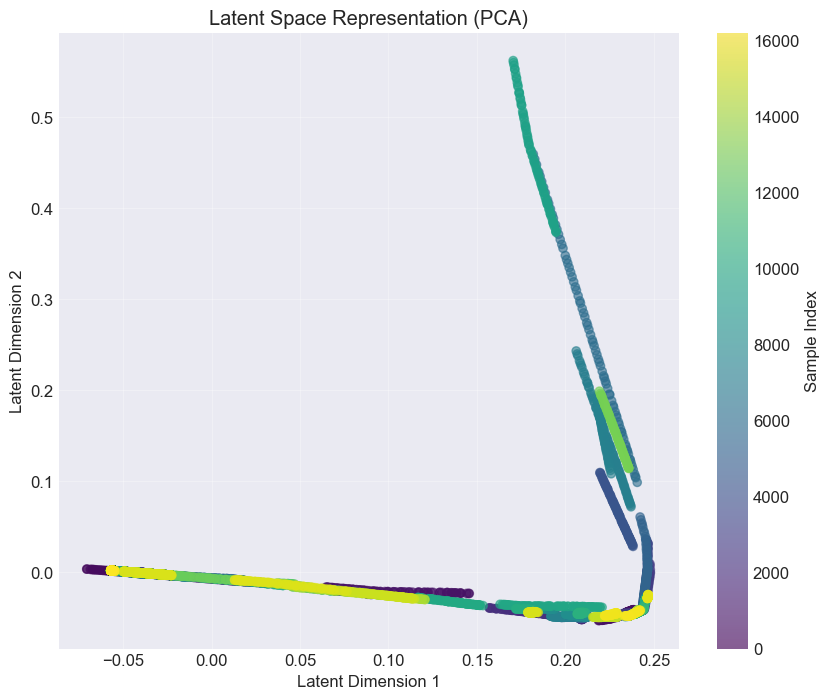

In [13]:
# Visualize latent space distribution
if latent_representations.shape[1] > 2:
    # Use PCA for dimensionality reduction
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)
    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
else:
    latent_2d = latent_representations

plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], 
                     c=np.arange(len(latent_2d)), cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Sample Index')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Representation (PCA)')
plt.grid(True, alpha=0.3)
plt.show()


Latent Space Statistics:
                z_0           z_1           z_2           z_3           z_4  \
count  16200.000000  16200.000000  16200.000000  16200.000000  16200.000000   
mean       0.002173     -0.021144      0.008193      0.013026     -0.061361   
std        0.003870      0.011941      0.007458      0.010772      0.028437   
min       -0.009528     -0.028462     -0.074403     -0.017217     -0.134958   
25%        0.003543     -0.027289      0.009531      0.016418     -0.076027   
50%        0.004143     -0.027201      0.009535      0.018419     -0.075757   
75%        0.004165     -0.025022      0.009729      0.018495     -0.068844   
max        0.004424      0.020694      0.011757      0.031895      0.016954   

                z_5           z_6           z_7           z_8           z_9  \
count  16200.000000  16200.000000  16200.000000  16200.000000  16200.000000   
mean       0.008665     -0.011298     -0.003476      0.065580      0.005244   
std        0.004965      

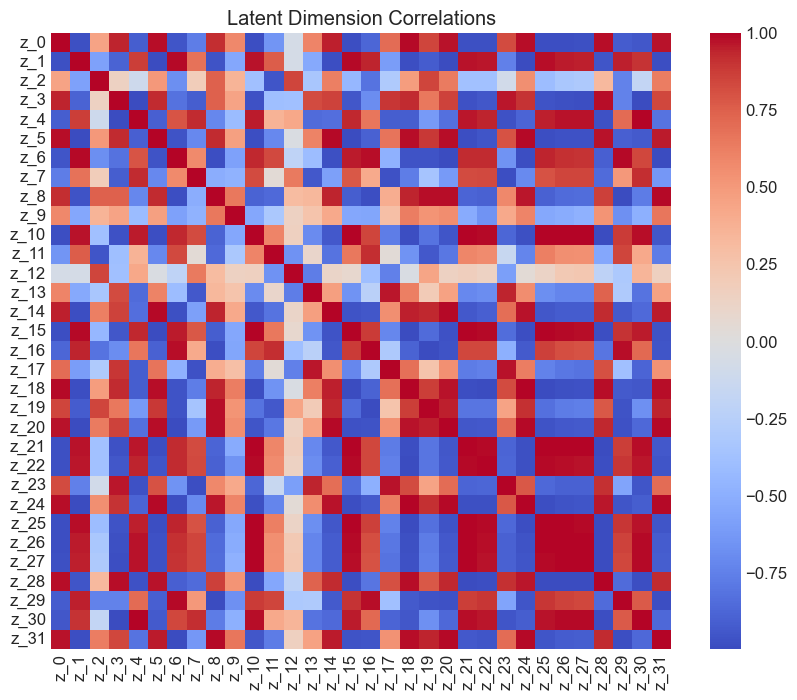

In [14]:
# Analyze latent space statistics
latent_stats = pd.DataFrame({
    f'z_{i}': latent_representations[:, i] 
    for i in range(latent_representations.shape[1])
})

print("\nLatent Space Statistics:")
print(latent_stats.describe())

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(latent_stats.corr(), cmap='coolwarm', center=0, 
            annot=True if latent_representations.shape[1] < 10 else False)
plt.title('Latent Dimension Correlations')
plt.show()

## 6. Physics Constraint Verification

In [15]:
# Evaluate physics constraints on predictions
if config['loss'].get('physics_weight', 0) > 0:
    from utils.lossfn import PhysicsConstraintLoss
    
    # Create physics loss function
    constraint_type = 'heat_equation' if config['dataset'] == 'heat1d' else 'advection_diffusion'
    physics_loss_fn = PhysicsConstraintLoss(constraint_type)
    
    # Prepare metadata
    metadata = {
        'dataset': config['dataset'],
        'dx': config.get('dx', 0.01),
        'dt': config.get('dt', 0.01),
        'alpha': config.get('alpha', 0.01),
        'D': config.get('D', 0.01),
        'vx': config.get('vx', 0.5),
        'vy': config.get('vy', 0.3)
    }
    
    # Evaluate on trajectory
    with torch.no_grad():
        # Get a trajectory prediction
        traj_tensor = torch.FloatTensor(pred_trajectory).unsqueeze(0).to(device)
        
        # Reshape if needed for 2D
        if is_2d and config['dataset'] == 'advection_diffusion_2d':
            traj_tensor = traj_tensor.reshape(1, -1, nx, ny)
        
        physics_violation = physics_loss_fn(traj_tensor, metadata).item()
    
    print(f"\nPhysics Constraint Violation: {physics_violation:.6f}")
    
    # Compare with ground truth physics violation
    with torch.no_grad():
        gt_tensor = torch.FloatTensor(u_full[:pred_trajectory.shape[0]]).unsqueeze(0).to(device)
        if is_2d and config['dataset'] == 'advection_diffusion_2d':
            gt_tensor = gt_tensor.reshape(1, -1, nx, ny)
        gt_physics_violation = physics_loss_fn(gt_tensor, metadata).item()
    
    print(f"Ground Truth Physics Violation: {gt_physics_violation:.6f}")
    print(f"Ratio (Model/GT): {physics_violation/gt_physics_violation:.2f}")


Physics Constraint Violation: 0.009076
Ground Truth Physics Violation: 164.937302
Ratio (Model/GT): 0.00


## 7. Koopman Operator Analysis

In [16]:
# Get Koopman operator matrix
try:
    K_matrix = model.get_koopman_matrix()
    print(f"Koopman operator shape: {K_matrix.shape}")
    
    # Compute eigenvalues
    eigenvalues = torch.linalg.eigvals(K_matrix).cpu().numpy()
    
    # Plot eigenvalue spectrum
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Complex plane
    axes[0].scatter(eigenvalues.real, eigenvalues.imag, alpha=0.6, s=50)
    axes[0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    axes[0].axvline(x=0, color='k', linestyle='-', alpha=0.3)
    
    # Unit circle
    theta = np.linspace(0, 2*np.pi, 100)
    axes[0].plot(np.cos(theta), np.sin(theta), 'r--', alpha=0.5, label='Unit circle')
    
    axes[0].set_xlabel('Real')
    axes[0].set_ylabel('Imaginary')
    axes[0].set_title('Koopman Eigenvalues')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_aspect('equal')
    
    # Eigenvalue magnitudes
    magnitudes = np.abs(eigenvalues)
    axes[1].bar(range(len(magnitudes)), np.sort(magnitudes)[::-1])
    axes[1].axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Unit magnitude')
    axes[1].set_xlabel('Eigenvalue Index')
    axes[1].set_ylabel('Magnitude')
    axes[1].set_title('Eigenvalue Magnitudes (sorted)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Stability analysis
    max_magnitude = np.max(magnitudes)
    unstable_count = np.sum(magnitudes > 1.0)
    
    print(f"\nKoopman Operator Analysis:")
    print(f"  Maximum eigenvalue magnitude: {max_magnitude:.4f}")
    print(f"  Number of unstable modes (|λ| > 1): {unstable_count}")
    print(f"  Spectral radius: {max_magnitude:.4f}")
    
    # Visualize Koopman matrix
    plt.figure(figsize=(10, 8))
    im = plt.imshow(K_matrix.numpy(), cmap='RdBu_r', aspect='auto')
    plt.colorbar(im)
    plt.title('Koopman Operator Matrix')
    plt.xlabel('Input Dimension')
    plt.ylabel('Output Dimension')
    plt.show()
    
except Exception as e:
    print(f"Could not analyze Koopman operator: {e}")


Koopman operator shape: torch.Size([32, 32])
Could not analyze Koopman operator: module 'torch.linalg' has no attribute 'eigvals'


## 8. Error Analysis and Statistics

In [17]:
# Comprehensive error analysis across test set
all_errors = {
    'reconstruction': [],
    'prediction_1step': [],
    'prediction_5step': [],
    'prediction_10step': []
}

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Computing errors"):
        inputs = batch['input'].to(device)
        targets = batch['target'].to(device)
        
        if inputs.dim() == 4:
            inputs = inputs.reshape(inputs.shape[0], inputs.shape[1], -1)
            targets = targets.reshape(targets.shape[0], targets.shape[1], -1)
        
        # Reconstruction error
        outputs = model(inputs[:, -1, :], n_steps=0)
        recon_error = torch.nn.functional.mse_loss(
            outputs['reconstruction'], 
            inputs[:, -1, :], 
            reduction='none'
        ).mean(dim=1).cpu().numpy()
        all_errors['reconstruction'].extend(recon_error)
        
        # Prediction errors
        if targets.shape[1] >= 10:
            outputs = model(inputs[:, -1, :], n_steps=10)
            predictions = outputs['predictions']
            
            for t in [0, 4, 9]:  # 1-step, 5-step, 10-step
                pred_error = torch.nn.functional.mse_loss(
                    predictions[:, t, :], 
                    targets[:, t, :], 
                    reduction='none'
                ).mean(dim=1).cpu().numpy()
                all_errors[f'prediction_{t+1}step'].extend(pred_error)

# Convert to arrays
for key in all_errors:
    all_errors[key] = np.array(all_errors[key])

Computing errors:   0%|          | 0/507 [00:00<?, ?it/s]

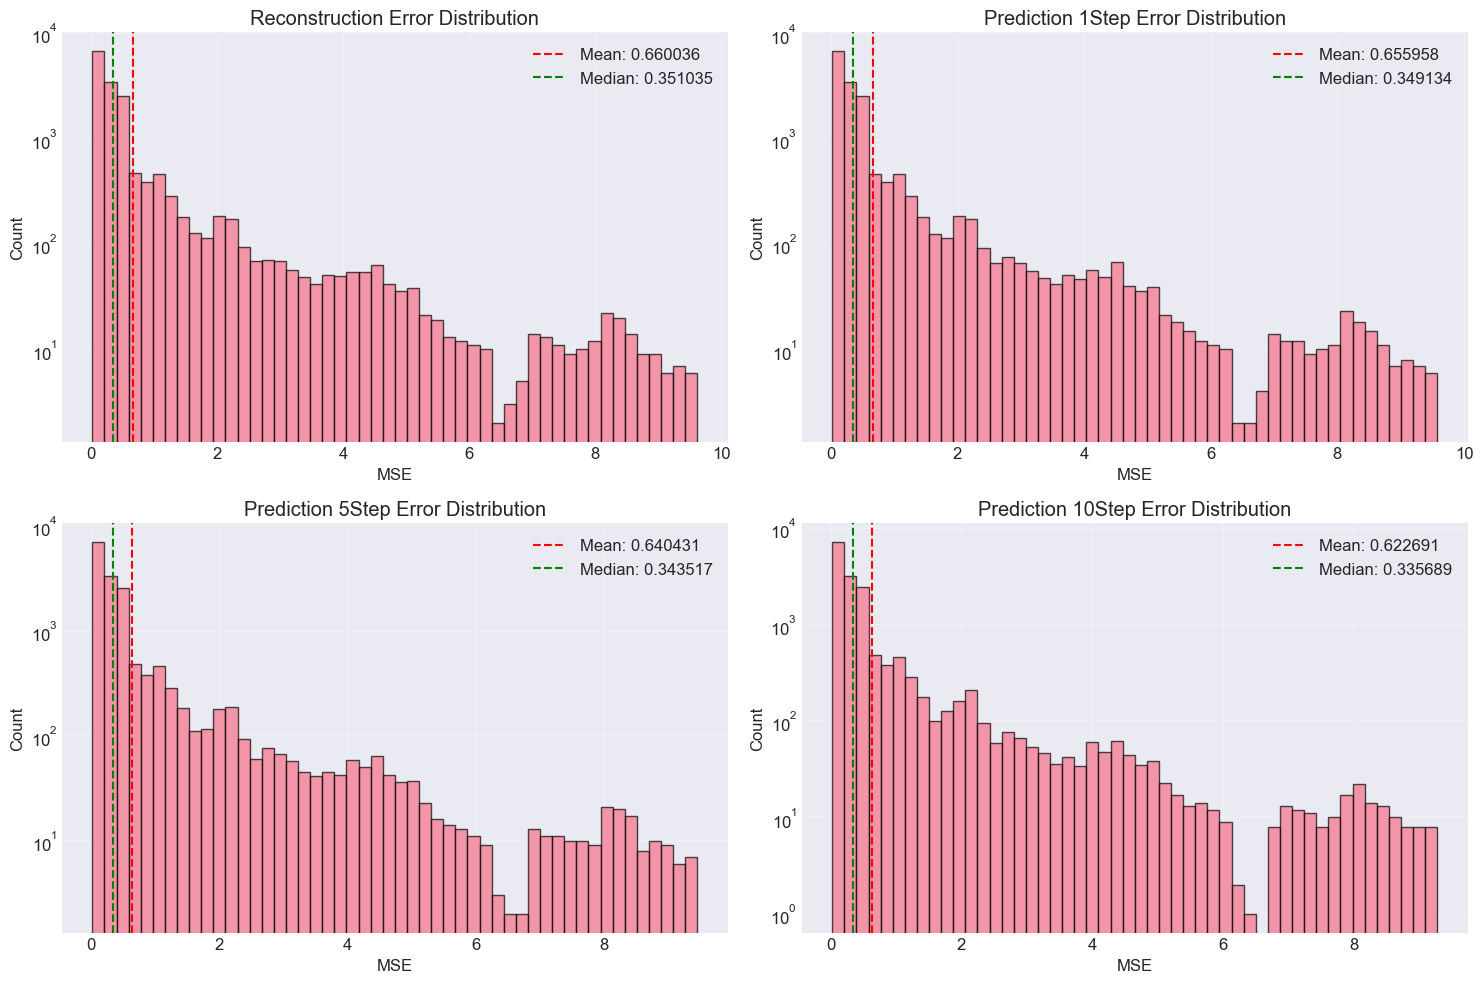


Error Summary Statistics:

reconstruction:
  Mean: 0.660036
  Std: 1.207575
  Min: 0.020047
  Max: 9.619560
  95th percentile: 3.037879

prediction_1step:
  Mean: 0.655958
  Std: 1.202424
  Min: 0.020021
  Max: 9.577139
  95th percentile: 3.008450

prediction_5step:
  Mean: 0.640431
  Std: 1.182744
  Min: 0.020032
  Max: 9.450727
  95th percentile: 2.919029

prediction_10step:
  Mean: 0.622691
  Std: 1.160134
  Min: 0.020019
  Max: 9.281137
  95th percentile: 2.826541


In [18]:
# Plot error distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, (error_type, errors) in enumerate(all_errors.items()):
    if len(errors) > 0:
        axes[i].hist(errors, bins=50, alpha=0.7, edgecolor='black')
        axes[i].axvline(np.mean(errors), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(errors):.6f}')
        axes[i].axvline(np.median(errors), color='green', linestyle='--', 
                       label=f'Median: {np.median(errors):.6f}')
        axes[i].set_xlabel('MSE')
        axes[i].set_ylabel('Count')
        axes[i].set_title(f'{error_type.replace("_", " ").title()} Error Distribution')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        axes[i].set_yscale('log')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nError Summary Statistics:")
for error_type, errors in all_errors.items():
    if len(errors) > 0:
        print(f"\n{error_type}:")
        print(f"  Mean: {np.mean(errors):.6f}")
        print(f"  Std: {np.std(errors):.6f}")
        print(f"  Min: {np.min(errors):.6f}")
        print(f"  Max: {np.max(errors):.6f}")
        print(f"  95th percentile: {np.percentile(errors, 95):.6f}")

## 9. Save Analysis Results

In [19]:
# Save all analysis results
results = {
    'model_path': MODEL_PATH,
    'config': config,
    'metrics': {
        'reconstruction_mse': float(recon_mse),
        'reconstruction_mae': float(recon_mae),
        'reconstruction_relative_error': float(recon_rel_error),
        'average_prediction_error': float(np.mean(pred_errors)),
        'physics_violation': float(physics_violation) if 'physics_violation' in locals() else None,
    },
    'error_statistics': {
        error_type: {
            'mean': float(np.mean(errors)),
            'std': float(np.std(errors)),
            'min': float(np.min(errors)),
            'max': float(np.max(errors)),
            'percentile_95': float(np.percentile(errors, 95))
        } for error_type, errors in all_errors.items() if len(errors) > 0
    },
    'koopman_analysis': {
        'max_eigenvalue_magnitude': float(max_magnitude) if 'max_magnitude' in locals() else None,
        'unstable_modes': int(unstable_count) if 'unstable_count' in locals() else None,
        'latent_dim': int(latent_representations.shape[1])
    }
}

# Save results
results_path = Path(MODEL_PATH).parent / 'evaluation_results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nResults saved to: {results_path}")


Results saved to: ..\..\results\checkpoints\koopman_ae_heat1d_20250611_184031\evaluation_results.json
